In [42]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sksurv.ensemble import GradientBoostingSurvivalAnalysis
from sksurv.metrics import concordance_index_censored, cumulative_dynamic_auc
from sklearn.metrics import confusion_matrix

# Load data
df = pd.read_csv("full_clean.csv")
df["gcs"] = df["gcs"].round().astype(int)
df["los"] = df["los"].clip(lower=1)

# Define survival target
y = np.array([(bool(e), t) for e, t in zip(df['event'], df['los'])],
             dtype=[('event', bool), ('time', float)])
features = [ 'age', 'sex', 'gcs', 'MOI', 'hr_cat', 'rr_cat', 'sbp_cat']
X = df[features]

# Preprocessing
categorical_features = ['MOI', 'sbp_cat', 'gcs']
numeric_features = ['age', 'sex', 'hr_cat', 'rr_cat']
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features),
    ('num', 'passthrough', numeric_features)
])
pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('gbsa', GradientBoostingSurvivalAnalysis(n_estimators=150, random_state=42))
])

# Setup
kf = KFold(n_splits=5, shuffle=True, random_state=42)
regions = df['region'].unique()
cindex_by_region = {region: [] for region in regions}
cindex_overall = []
auc_matrix = []
sensitivities = []
specificities = []

# Evaluation days
eval_days = np.array([1, 5, 10, 15, 30, 60, 90])

for train_idx, test_idx in kf.split(X):
    X_train_raw = df.iloc[train_idx][features].copy()
    X_test_raw = df.iloc[test_idx][features].copy()
    y_train, y_test = y[train_idx], y[test_idx]
    test_regions = df.iloc[test_idx]['region'].values  # <- keep region separately
    # Map binary strings
    for col, mapping in {'hr_cat': {'normal': 0, 'tachycardia': 1}, 'rr_cat': {'normal': 0, 'tachypnea': 1}}.items():
        X_train_raw[col] = X_train_raw[col].map(mapping)
        X_test_raw[col] = X_test_raw[col].map(mapping)

    pipeline.fit(X_train_raw, y_train)
    pred_risk = pipeline.predict(X_test_raw)

    # Overall C-index
    cidx = concordance_index_censored(y_test["event"], y_test["time"], pred_risk)[0]
    cindex_overall.append(cidx)

    # Region-wise C-index
    for region in regions:
        mask = test_regions == region
        if np.sum(mask) == 0:
            continue
        region_y = y_test[mask]
        region_pred = pred_risk[mask]
        c = concordance_index_censored(region_y["event"], region_y["time"], region_pred)[0]
        cindex_by_region[region].append(c)

    # AUC at eval_days
    safe_days = eval_days[(eval_days >= y_test["time"].min()) & (eval_days <= y_test["time"].max() - 1e-6)]
    try:
        _, aucs = cumulative_dynamic_auc(y_train, y_test, pred_risk, times=safe_days)
        padded = np.full(len(eval_days), np.nan)
        for i, d in enumerate(eval_days):
            if d in safe_days:
                padded[i] = aucs[np.where(safe_days == d)[0][0]]
        auc_matrix.append(padded)
    except:
        auc_matrix.append(np.full(len(eval_days), np.nan))

    # Sensitivity/specificity from thresholding
    median_time = np.median(y_test["time"])
    y_binary = y_test["time"] <= median_time
    pred_binary = pred_risk >= np.median(pred_risk)
    tn, fp, fn, tp = confusion_matrix(y_binary, pred_binary).ravel()
    sens = tp / (tp + fn) if (tp + fn) else 0
    spec = tn / (tn + fp) if (tn + fp) else 0
    sensitivities.append(sens)
    specificities.append(spec)


In [43]:

# --- Print Output ---
print("\n--- OVERALL METRICS ---")
print("C-index:       {:.3f} ± {:.3f}".format(np.nanmean(cindex_overall), np.nanstd(cindex_overall)))


# Region-wise C-index
print("\n--- REGION-WISE C-INDEX ---")
for region in regions:
    scores = cindex_by_region[region]
    if len(scores) > 0:
        print(f"{region:<15} → C-index: {np.mean(scores):.3f} ± {np.std(scores):.3f}")
    else:
        print(f"{region:<15} → C-index: NA (insufficient samples)")



--- OVERALL METRICS ---
C-index:       0.767 ± 0.003

--- REGION-WISE C-INDEX ---
Jordan          → C-index: 0.846 ± 0.083
India           → C-index: 0.775 ± 0.005
California      → C-index: 0.807 ± 0.059
Florida         → C-index: 0.479 ± 0.076


In [44]:
# Remap binary fields for full dataset
X_full = X.copy()
X_full['hr_cat'] = X_full['hr_cat'].map({'normal': 0, 'tachycardia': 1})
X_full['rr_cat'] = X_full['rr_cat'].map({'normal': 0, 'tachypnea': 1})

# Fit full pipeline
pipeline.fit(X_full, y)

# Save model
import joblib
joblib.dump(pipeline, "gbsa_final_model.pkl")
print("Model trained on full dataset and saved as gbsa_final_model.pkl")


Model trained on full dataset and saved as gbsa_final_model.pkl


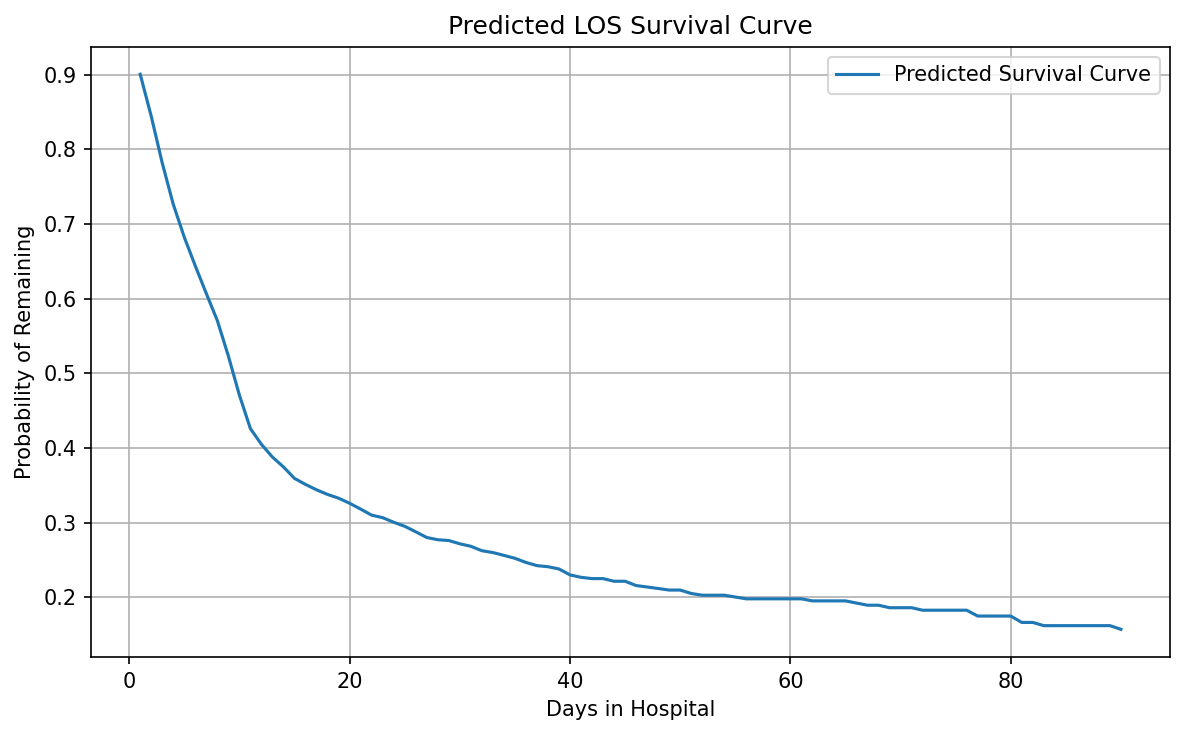

Probability of staying > 1 days: 0.901
Probability of staying > 5 days: 0.682
Probability of staying > 10 days: 0.471
Probability of staying > 15 days: 0.359
Probability of staying > 30 days: 0.272
Probability of staying > 60 days: 0.198
Probability of staying > 90 days: 0.157


In [53]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
from sksurv.util import Surv

# Load model
model = joblib.load("gbsa_final_model.pkl")

# Define a sample patient (edit as needed!)
sample_patient = pd.DataFrame([{
    'region': 'Florida',
    'age': 39,
    'sex': 1,
    'gcs': 5,
    'MOI': 'Motor Vehicle Collision',
    'hr_cat': 0,  # Already mapped to 0/1
    'rr_cat': 1,  # Already mapped to 0/1
    'sbp_cat': 'low'
}])

# Predict survival function
surv_fn = model.predict_survival_function(sample_patient)
times = np.linspace(1, 90, 90)

# Plot survival curve
plt.figure(figsize=(8, 5), dpi=150)
plt.plot(times, surv_fn[0](times), label='Predicted Survival Curve')
plt.xlabel("Days in Hospital")
plt.ylabel("Probability of Remaining")
plt.title("Predicted LOS Survival Curve")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Print LOS probabilities at key timepoints
for t in [1, 5, 10, 15, 30, 60, 90]:
    prob = surv_fn[0](t)
    print(f"Probability of staying > {t} days: {prob:.3f}")


In [46]:
import shap

# Get the trained GBSA model only (not pipeline)
gbsa_model = pipeline.named_steps['gbsa']

# Transform X with the fitted preprocessor
X_transformed = pipeline.named_steps['preprocess'].transform(X_full)

# Initialize SHAP explainer
explainer = shap.Explainer(gbsa_model.predict, X_transformed)
shap_values = explainer(X_transformed)

# Summary plot
shap.summary_plot(shap_values, X_transformed)


PermutationExplainer explainer:  15%|█▍        | 1327/8936 [00:24<03:56, 32.20it/s]


KeyboardInterrupt: 

['cat__MOI_Assault / Blunt Force' 'cat__MOI_Bicycle Crash'
 'cat__MOI_Burn / Fire / Blast' 'cat__MOI_Fall'
 'cat__MOI_Gunshot Wound (GSW)' 'cat__MOI_Motor Vehicle Collision'
 'cat__MOI_Motorcycle Crash' 'cat__MOI_Other / Unknown'
 'cat__MOI_Pedestrian Struck' 'cat__sbp_cat_low' 'cat__sbp_cat_normal'
 'num__age' 'num__gcs' 'num__sex' 'num__hr_cat' 'num__rr_cat']


C:\Users\lutzl\AppData\Local\Temp\ipykernel_39760\2799304883.py:8: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_transformed, feature_names=input_features)


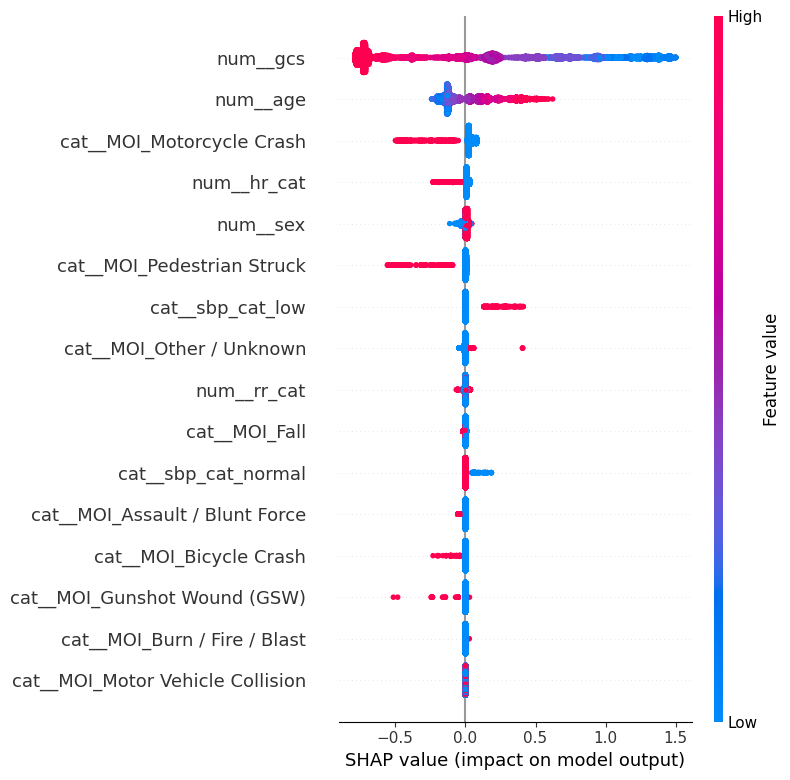

In [ ]:
# Get transformed feature names
input_features = pipeline.named_steps['preprocess'].get_feature_names_out()

# Show them (optional)
print(input_features)

# Re-plot with proper feature names
shap.summary_plot(shap_values, X_transformed, feature_names=input_features)


C:\Users\lutzl\AppData\Local\Temp\ipykernel_39760\3884032818.py:28: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_transformed, feature_names=pretty_names)


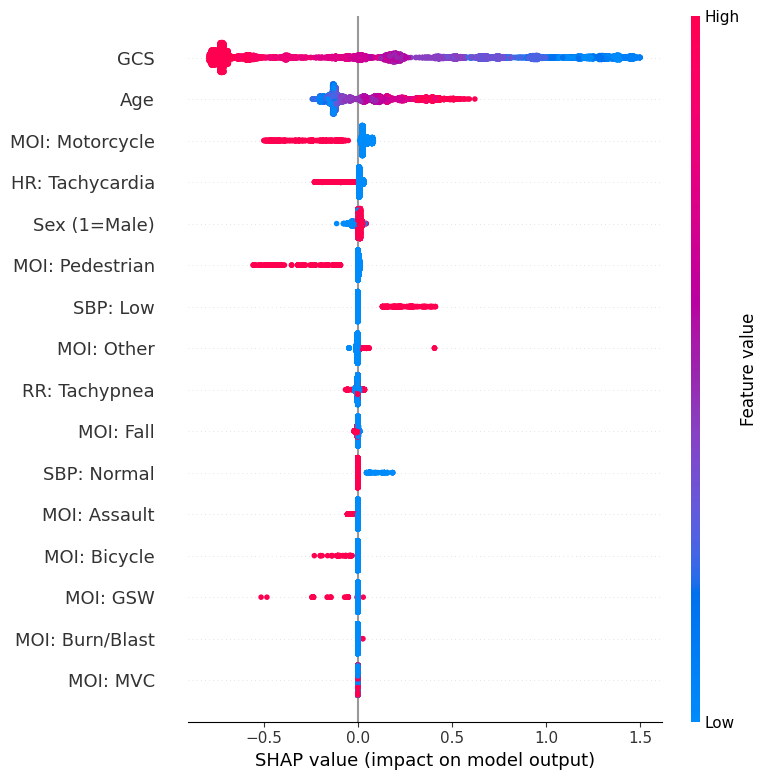

In [ ]:
pretty_feature_names = {
    'cat__region_Florida': 'Region: Florida',
    'cat__region_India': 'Region: India',
    'cat__region_Jordan': 'Region: Jordan',
    'cat__MOI_Assault / Blunt Force': 'MOI: Assault',
    'cat__MOI_Bicycle Crash': 'MOI: Bicycle',
    'cat__MOI_Burn / Fire / Blast': 'MOI: Burn/Blast',
    'cat__MOI_Fall': 'MOI: Fall',
    'cat__MOI_Gunshot Wound (GSW)': 'MOI: GSW',
    'cat__MOI_Motor Vehicle Collision': 'MOI: MVC',
    'cat__MOI_Motorcycle Crash': 'MOI: Motorcycle',
    'cat__MOI_Other / Unknown': 'MOI: Other',
    'cat__MOI_Pedestrian Struck': 'MOI: Pedestrian',
    'cat__sbp_cat_low': 'SBP: Low',
    'cat__sbp_cat_normal': 'SBP: Normal',
    'num__age': 'Age',
    'num__gcs': 'GCS',
    'num__sex': 'Sex (1=Male)',
    'num__hr_cat': 'HR: Tachycardia',
    'num__rr_cat': 'RR: Tachypnea'
}

# Apply mapping to feature names
input_features = pipeline.named_steps['preprocess'].get_feature_names_out()
pretty_names = [pretty_feature_names.get(f, f) for f in input_features]

# Re-plot summary
shap.summary_plot(shap_values, X_transformed, feature_names=pretty_names)


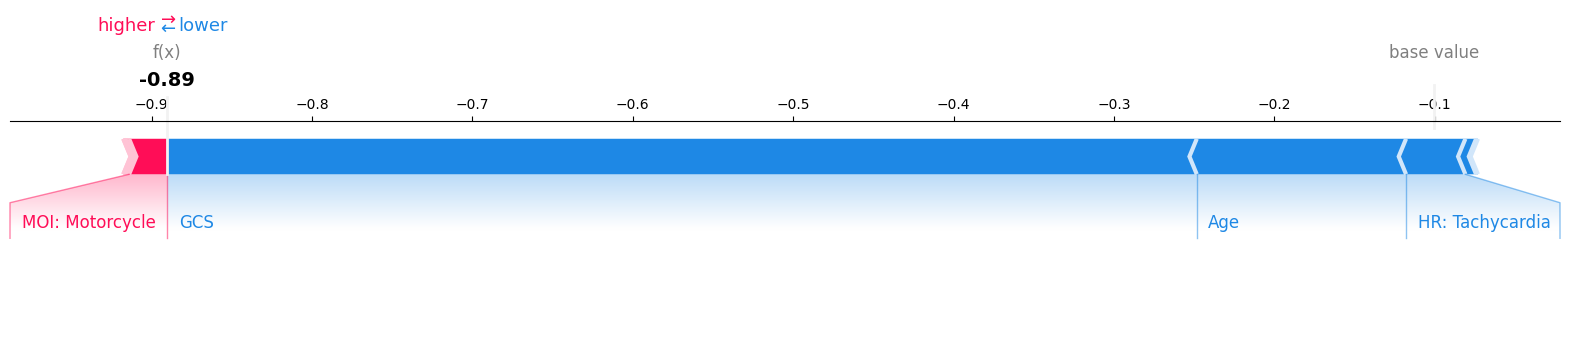

In [ ]:
# Select patient index
patient_index = 0

# SHAP values for the individual
shap_val = shap_values[patient_index]
transformed_row = X_transformed[patient_index]

# Force plot (interactive)
shap.initjs()
shap.force_plot(
    shap_values.base_values[patient_index], 
    shap_val.values, 
    feature_names=pretty_names,
    matplotlib=True
)
